In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from pandas import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from pandas import Series

from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.model_selection import train_test_split

# ADFuller test function

In [2]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

# Cointegration Johanson Test

In [3]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


In [4]:
# dataset united kingdom
#case = pd.read_csv('UK/case.csv')
#mobility = pd.read_csv('UK/mobility.csv')
#case.set_index('date', inplace=True)
#mobility.set_index('date', inplace=True)

# dataset indonesia (jakarta)
case = pd.read_csv('data/new/case_maret_july.csv')
mobility = pd.read_csv('data/new/mobility_maret_july.csv')
weather = pd.read_csv('data/new/weather_maret_july.csv')
case.set_index('date', inplace=True)
#weather.set_index('date', inplace=True)
mobility.set_index('date', inplace=True)

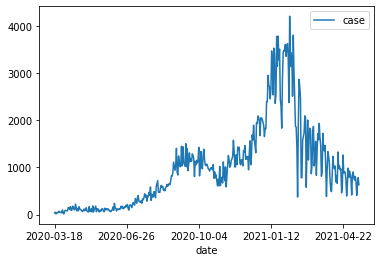

In [5]:
case.plot()
plt.show()

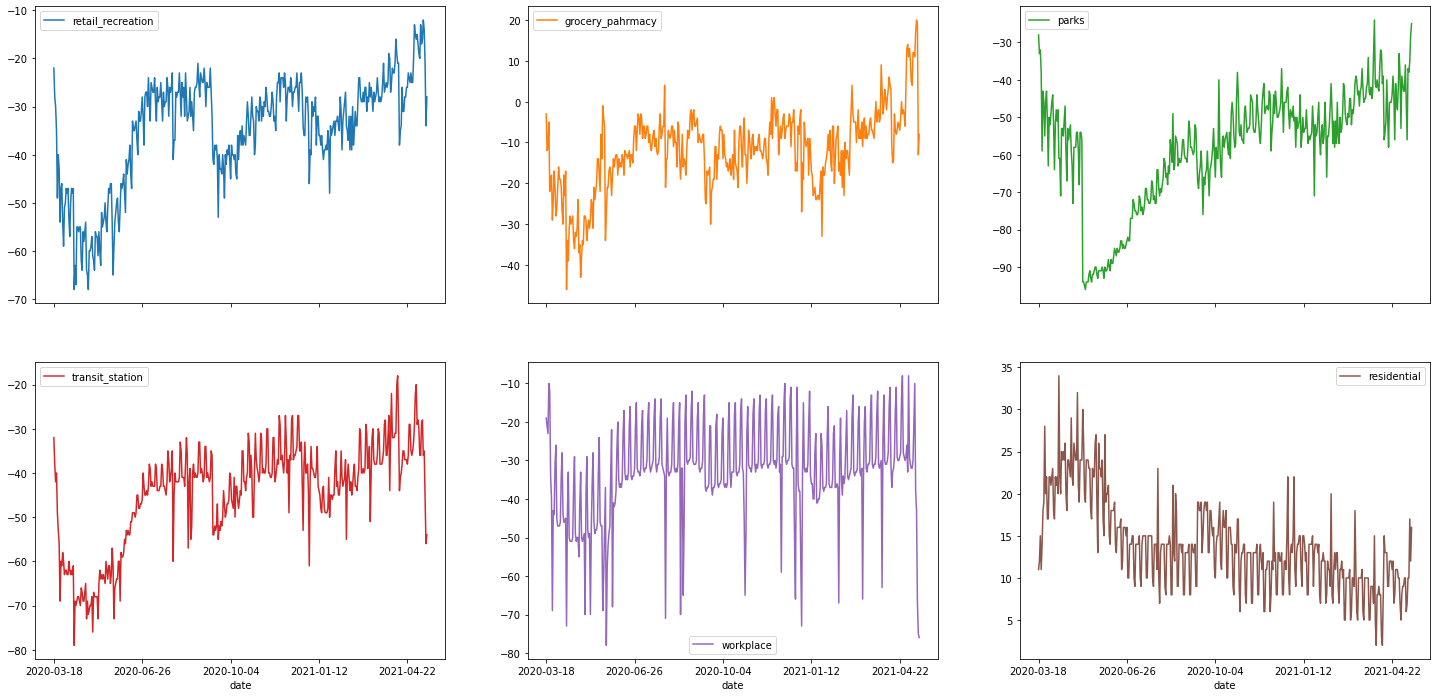

In [6]:
mobility.plot(subplots=True, layout=(2,3), figsize=(25,12))
plt.show()

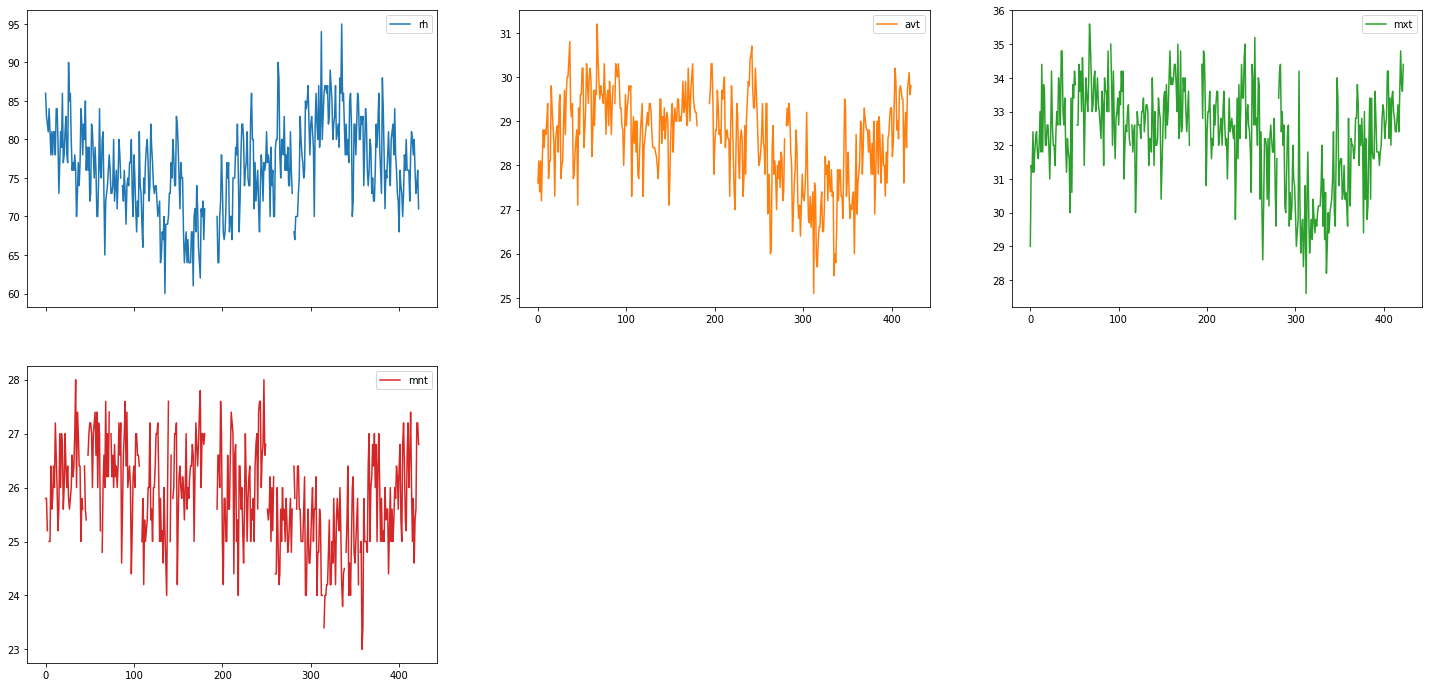

In [7]:
weather.plot(subplots=True, layout=(2,3), figsize=(25,12))
plt.show()

# Interpolasi data weather

In [8]:
new_weather = weather.interpolate(method='spline', order=2)
new_weather.head()

new_weather.set_index('date', inplace=True)

In [9]:
# ADF test untuk mobility london
for name, column in mobility.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "retail_recreation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8034
 No. Lags Chosen       = 14
 Critical value 1%     = -3.446
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.3788. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "grocery_pahrmacy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0261
 No. Lags Chosen       = 13
 Critical value 1%     = -3.446
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.2753. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "parks" 
    -----------------------------------------------
 Null 

In [10]:
# ADF test untuk mobility london
for name, column in new_weather.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rh" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4071
 No. Lags Chosen       = 6
 Critical value 1%     = -3.446
 Critical value 5%     = -2.869
 Critical value 10%    = -2.57
 => P-Value = 0.0107. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "avt" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.7355
 No. Lags Chosen       = 5
 Critical value 1%     = -3.446
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0036. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "mxt" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


# Differencing untuk data mobility + sesuaikan index case

In [11]:
# Differencing order = 1
mobility_diff = mobility.diff(periods=1)
mobility_diff = mobility_diff.iloc[1:]
case = case.iloc[1:]
new_weather = new_weather.iloc[1:]
mobility_diff.head()

,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential
date,,,,,,
2020-03-19,-6.0,-9.0,-5.0,-6.0,-2.0,1.0
2020-03-20,-2.0,1.0,1.0,-4.0,-2.0,3.0
2020-03-21,-5.0,6.0,-6.0,2.0,13.0,-4.0
2020-03-22,-14.0,-17.0,-21.0,-9.0,-2.0,3.0
2020-03-23,9.0,3.0,16.0,-4.0,-22.0,4.0


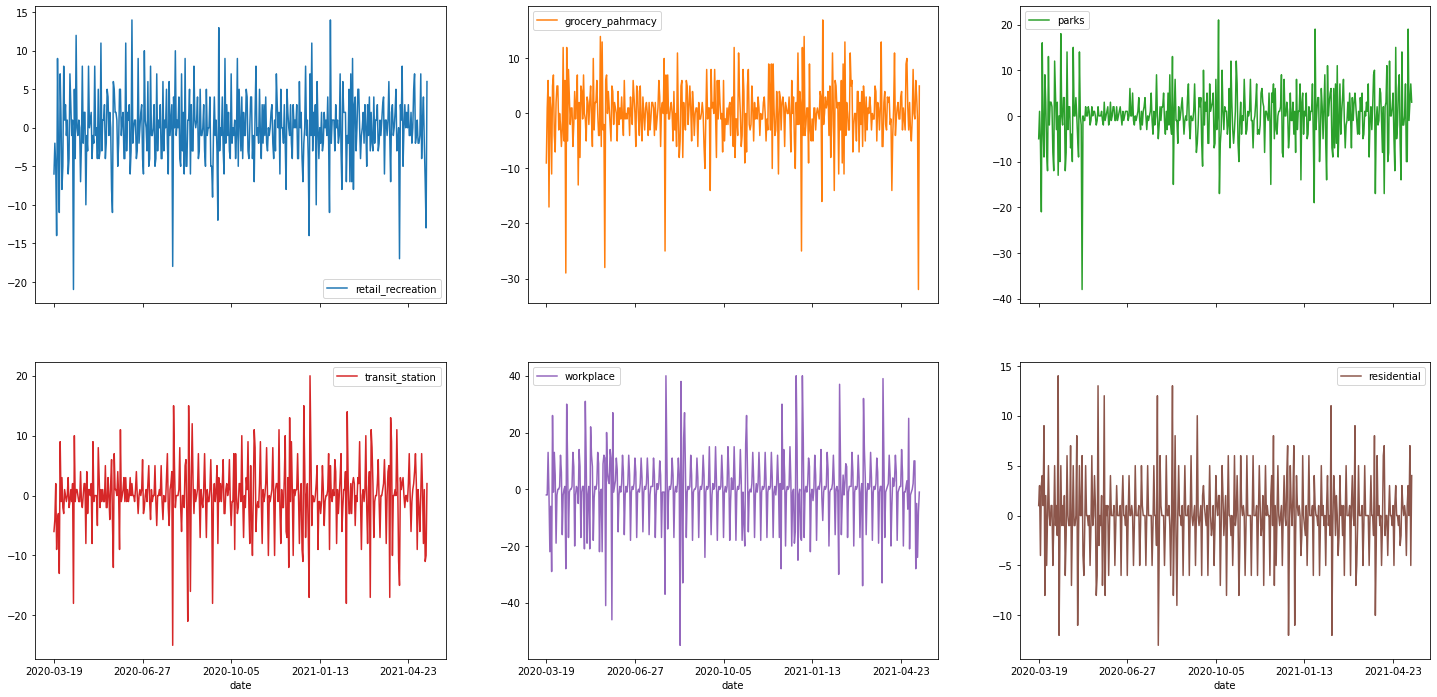

In [12]:
mobility_diff.plot(subplots=True, layout=(2,3), figsize=(25,12))
plt.show()

In [13]:
# ADF test untuk mobility london
for name, column in mobility_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "retail_recreation" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8636
 No. Lags Chosen       = 13
 Critical value 1%     = -3.446
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "grocery_pahrmacy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1786
 No. Lags Chosen       = 12
 Critical value 1%     = -3.446
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "parks" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 S

In [14]:
data = pd.concat([case, new_weather, mobility_diff], axis=1)
data.head()

,case,rh,avt,mxt,mnt,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential
date,,,,,,,,,,,
2020-03-19,50,83.0,28.1,31.4,25.800000,-6.0,-9.0,-5.0,-6.0,-2.0,1.0
2020-03-20,14,82.0,27.4,31.2,25.200000,-2.0,1.0,1.0,-4.0,-2.0,3.0
2020-03-21,44,81.0,28.1,32.4,26.521978,-5.0,6.0,-6.0,2.0,13.0,-4.0
2020-03-22,36,84.0,27.2,31.2,25.000000,-14.0,-17.0,-21.0,-9.0,-2.0,3.0
2020-03-23,51,81.0,28.2,31.8,25.000000,9.0,3.0,16.0,-4.0,-22.0,4.0


In [15]:
cointegration_test(data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
case   ::  1456.9    > 263.2603  =>   True
rh     ::  793.77    > 219.4051  =>   True
avt    ::  613.92    > 179.5199  =>   True
mxt    ::  459.34    > 143.6691  =>   True
mnt    ::  336.21    > 111.7797  =>   True
retail_recreation ::  232.4     > 83.9383   =>   True
grocery_pahrmacy ::  145.62    > 60.0627   =>   True
parks  ::  84.63     > 40.1749   =>   True
transit_station ::  25.71     > 24.2761   =>   True
workplace ::  2.51      > 12.3212   =>   False
residential ::  0.01      > 4.1296    =>   False


In [16]:
#i = 1
#j = 1

#for i in range(1, 16, 1):
#    for j in range(1, 16, 1):
#        warnings.filterwarnings('ignore')
#        model = VARMAX(data, order=(i, j))
#        model_fit = model.fit(maxiter=100, disp=False)
#        print("VARMA Order :", i,j)
#        print("AIC Model :", model_fit.aic)

In [17]:
model = VARMAX(data, order=(1, 1))
model_fit = model.fit(disp=False)
print(model_fit.summary())

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                                                                    Statespace Model Results                                                                                    
Dep. Variable:     ['case', 'rh', 'avt', 'mxt', 'mnt', 'retail_recreation', 'grocery_pahrmacy', 'parks', 'transit_station', 'workplace', 'residential']   No. Observations:                  422
Model:                                                                                                                                       VARMA(1,1)   Log Likelihood              -11843.170
                                                                                                                                            + intercept   AIC                          24324.341
Date:                                                                                                                                  Sun, 22 Aug 2021   BIC                          25614.698
Time:                              

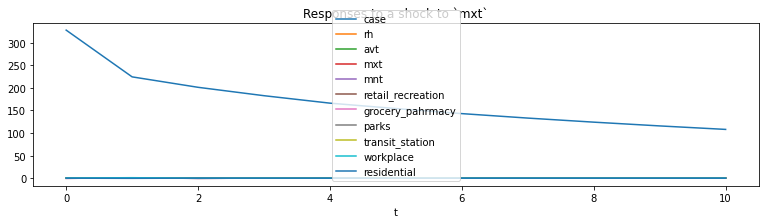

In [18]:
ax = model_fit.impulse_responses(10, orthogonalized=True).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses to a shock to `mxt`');

In [19]:
yhat = model_fit.forecast(exog=data)
print(yhat)

                  case         rh        avt        mxt        mnt  \
2021-05-15  602.845525  73.369766  29.322001  33.267257  26.523007   

            retail_recreation  grocery_pahrmacy     parks  transit_station  \
2021-05-15           1.239826          5.049583  1.293579         2.659803   

            workplace  residential  
2021-05-15   0.362752    -2.225501  


In [20]:
hasil = model_fit.forecast(17)

In [21]:
list_hasil = hasil['case'].tolist()

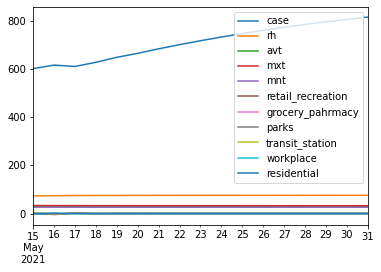

In [22]:
hasil.plot()
plt.show()

In [23]:
model_fit.forecast(17)

,case,rh,avt,mxt,mnt,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential
2021-05-15,602.845525,73.369766,29.322001,33.267257,26.523007,1.239826,5.049583,1.293579,2.659803,0.362752,-2.225501
2021-05-16,617.549690,73.932642,29.143401,32.974178,26.308800,-3.224748,-5.029088,-3.137827,-1.698640,1.573293,0.665368
2021-05-17,611.918670,74.828160,28.977472,32.874165,26.173023,1.880604,2.058018,1.318447,0.470212,-1.170684,-0.113315
2021-05-18,629.163605,75.037857,28.929551,32.754377,26.120568,-0.750651,-0.620079,-0.404495,-0.230543,-0.292274,0.186286
2021-05-19,649.963095,75.268739,28.874845,32.713484,26.066034,0.069305,-0.012026,-0.143437,0.027995,0.303309,-0.143191
2021-05-20,666.392564,75.398109,28.850834,32.674319,26.046012,-0.008880,-0.014235,0.047872,-0.110812,-0.431264,0.111563
2021-05-21,685.352114,75.493706,28.828228,32.645835,26.027136,-0.027795,0.011860,-0.046767,-0.012212,-0.027947,-0.032656
2021-05-22,702.658122,75.562629,28.812497,32.623748,26.014145,-0.041410,-0.049772,-0.036954,-0.065632,-0.146398,0.021239
2021-05-23,719.003070,75.623399,28.798211,32.604689,26.003374,-0.007034,0.010058,-0.009421,-0.041215,-0.135264,0.005857
2021-05-24,734.430250,75.671699,28.786274,32.587566,25.994294,-0.029699,-0.017399,-0.023765,-0.048788,-0.129709,0.009193


In [24]:
evalu = pd.read_csv('data/new/evaluation.csv')

In [25]:
list_eval = evalu['case'].tolist()

In [26]:
test_list = [int(i) for i in list_hasil]
test_list

[602,
 617,
 611,
 629,
 649,
 666,
 685,
 702,
 719,
 734,
 748,
 762,
 774,
 786,
 797,
 807,
 817]

In [27]:
rms = mean_squared_error(list_eval, test_list, squared=False)

In [28]:
rms

235.00588227932158

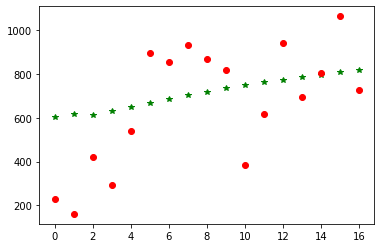

In [29]:
plt.plot(list_hasil,'g*', list_eval, 'ro')
plt.show()

In [30]:
test_list

[602,
 617,
 611,
 629,
 649,
 666,
 685,
 702,
 719,
 734,
 748,
 762,
 774,
 786,
 797,
 807,
 817]

In [31]:
list_eval

[227,
 161,
 421,
 291,
 539,
 895,
 856,
 932,
 867,
 819,
 384,
 617,
 940,
 693,
 807,
 1064,
 726]

In [32]:
mse = mean_squared_error(list_eval, test_list)

In [33]:
mse

55227.76470588235

In [34]:
mae = mean_absolute_error(list_eval, test_list)
mae

203.41176470588235